In [1]:
#! git pull

Already up-to-date.


## Import the azureml.core package

In [1]:
from azureml.core import Experiment, Run, Workspace
import azureml.core

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.14.0


### Update the workspace enviroment with your enviroment details

In [2]:
ws = Workspace.from_config()

ws.name

'MLServiceWrokspace'

### We will now create an experiment and load in all the packages we need to run
#### We are using the iris dataset to predict the species of flower in three experiments using a decision tree. Each experiment will have different tree depths to show how different levels of accuracy are displayed.


In [3]:
experiment_name = 'IrisPredC1'

In [46]:
#!pip install seaborn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.externals import joblib
import joblib
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

irisds = load_iris()

iris = sns.load_dataset("iris")
print(iris.head())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [6]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


#### Split the data into testing and training - stratify so we get an even split

# ![image.png](attachment:image.png)

In [5]:
#Split the data int a label and the features
y = iris.species #Label
X = iris.drop('species',axis=1) #Features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, #Split 70-30
                                                    random_state=100, 
                                                    stratify=y) #Stratify by the species to make sure we have a fair sampling

In [8]:
#Make sure we have a 70/30 split
print("Training = ", y_train.count(), "Testing = ", y_test.count())

Training =  105 Testing =  45


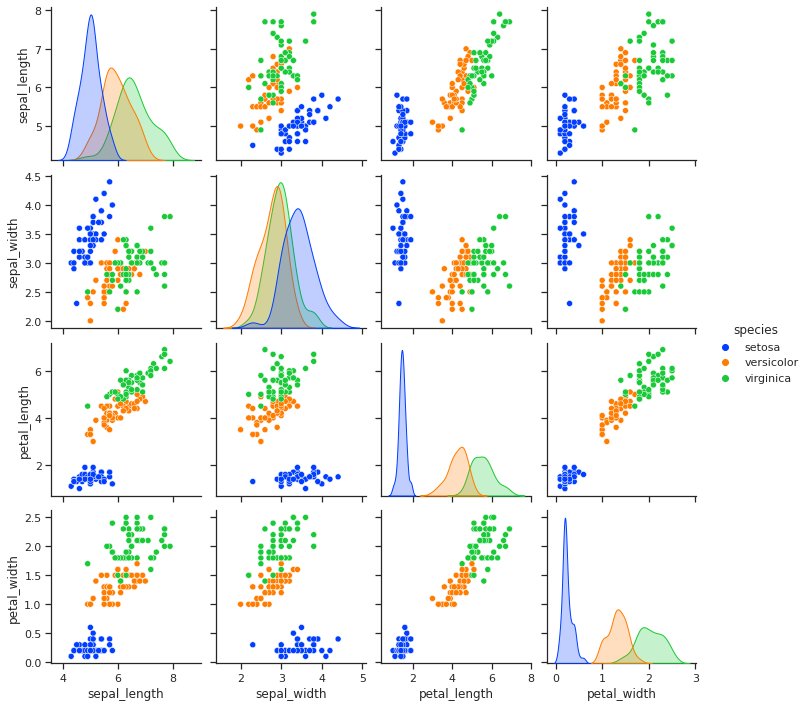

In [51]:
#Show our data
sns.set(style="ticks")
iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species",palette="bright")
plt.show()

### A closer brakdown of the relationship between the species 


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.


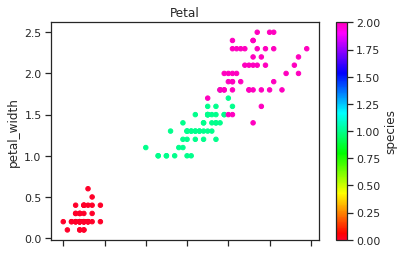

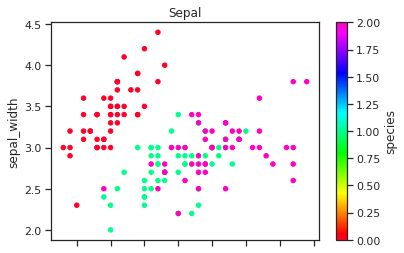

In [52]:
sns.set(style="ticks")
iris = sns.load_dataset("iris")
irispl = iris.loc[ : , ['petal_length', 'petal_width', 'species'] ]
irispl.species = pd.factorize(irispl.species)[0]
irispl.plot.scatter(x='petal_length', y='petal_width', c='species', cmap='gist_rainbow', title="Petal")

irisse = iris.loc[ : , ['sepal_length', 'sepal_width', 'species'] ]
irisse.species = pd.factorize(irisse.species)[0]
irisse.plot.scatter(x='sepal_length', y='sepal_width', c='species', cmap='gist_rainbow', title="Sepal")


plt.show()

### Experiment to see if we can write an algorithm without using machine learning

In [53]:
#We can write our own single level tree that does a better job
def iriscustompred(sepal_length, sepal_width, petal_length, petal_width):
    if petal_length + petal_width < 3:
        return('setosa')
    else:
        if petal_length + petal_width < 7:
            return('versicolor')
        else: 
            return('virginica')
        
idemopred = iris

idemopred['pred'] = np.vectorize(iriscustompred)(idemopred['sepal_length'], idemopred['sepal_width'], idemopred['petal_length'], idemopred['petal_width'])
wrongPredictionCount = sum(abs(idemopred['pred']!=idemopred['species']))
#print(idemopred)
print("Number of Wrong Predictions : " + str(wrongPredictionCount))
print("Accuracy : " + str(((idemopred.iloc[:,0].count() - wrongPredictionCount)/idemopred.iloc[:,0].count()) * 100))


Number of Wrong Predictions : 10
Accuracy : 93.33333333333333


### Create an experiment object
### Create a simple clasification decision tree model
### Test for accuracy
### Log metrics

[[15  0  0]
 [ 0 15  0]
 [ 0  3 12]]
Accuracy Score
93.33333333333333
CPU times: user 1.7 s, sys: 708 ms, total: 2.41 s
Wall time: 1min 36s


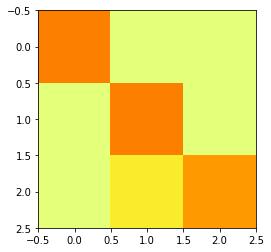

In [7]:
%%time

#Naive Bayes
from sklearn.naive_bayes import GaussianNB

#Create an experiment
experiment = Experiment(workspace=ws, name=experiment_name)
#Begin logging
run = experiment.start_logging()

##Tag in Azure
run.tag("Description","naive_bayes")
run.log('naive_bayes', 'GaussianNB')

#Run the training
clf = GaussianNB()
clf.fit(X_train, y_train)

#Predict with test data
y_pred = (clf.predict(X_test))

#Record Accuracy etc
run.log('Accuracy', (accuracy_score(y_test, y_pred)* 100))

#Dump the model to disk
joblib.dump(value=clf, filename='naive_bayes.pkl')
#Upload model to Azure
run.upload_file(name='outputs/naive_bayes.pkl', path_or_stream='./naive_bayes.pkl')

#Show the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

#Save the confusion Matrix
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
run.log_image("ConfusionMatrix", path=None, plot=plt)

#Log some fake data to show in our metrics
run.log_list('Fake Data', [0,0,1,1,2,3,5,8,13])

print('Accuracy Score');
print(accuracy_score(y_test, y_pred)* 100);


run.complete()



### View the tree that we have made

In [55]:
#! pip install graphviz
#! sudo apt-get install graphviz -y

In [56]:
#import graphviz 
#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("iris") 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                         filled=True, rounded=True,  
#                         special_characters=True)  
#graph = graphviz.Source(dot_data)  
#graph 

### Show the notebook widget related to our run
#### If this was a longer experiment we could run async and show reatime status in here

In [57]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Experiment 2 (Tree)

[[15  0  0]
 [ 0 15  0]
 [ 0  2 13]]
Accuracy Score
95.55555555555556
CPU times: user 1.32 s, sys: 407 ms, total: 1.73 s
Wall time: 56.3 s


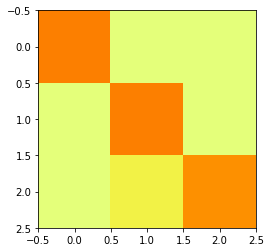

In [10]:
%%time

experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging()

##Tag in Azure
run.tag("Description","tree")
run.log('tree', 'DecisionTreeClassifier')

#Run the training
clf = tree.DecisionTreeClassifier(max_depth=20, criterion="gini", random_state=1)
clf.fit(X_train,y_train)
#PRedict with test data
y_pred = (clf.predict(X_test))

#Record Accuracy etc
run.log('Accuracy', (accuracy_score(y_test, y_pred)* 100))

#Upload model
joblib.dump(value=clf, filename='DecisionTreeClassifier.pkl')
run.upload_file(name='outputs/DecisionTreeClassifier.pkl', path_or_stream='./DecisionTreeClassifier.pkl')

cm = confusion_matrix(y_test, y_pred)
print(cm)

#Save the confusion Matrix
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
#plt.show()
run.log_image("ConfusionMatrix", path=None, plot=plt)

run.log_list('Fake Data', [0,0,1,1,2,3,5,8,13])

run.complete()

print ('Accuracy Score');
print (accuracy_score(y_test, y_pred)* 100);

In [59]:
#! pip install graphviz
#!sudo apt-get install graphviz -y

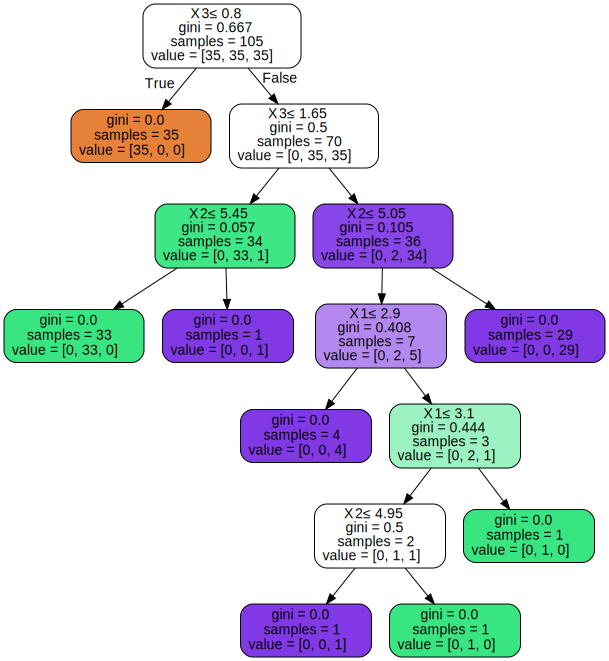

In [11]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Experiment 3 (NN)

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


Accuracy Score
97.77777777777777
CPU times: user 5.33 s, sys: 1.35 s, total: 6.69 s
Wall time: 58.7 s


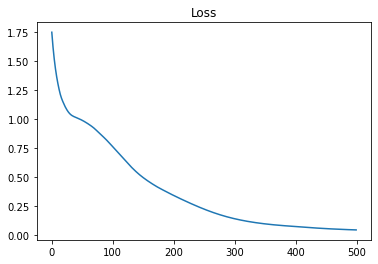

In [12]:
%%time

from sklearn.neural_network import MLPClassifier
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient
from interpret.ext.blackbox import TabularExplainer

experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging()

##Tag in Azure
run.tag("Description","neural network")
run.log('neural network', 'MLPClassifier')

#Run the training
clf = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=500)
clf.fit(X_train,y_train)

#PRedict with test data
y_pred = (clf.predict(X_test))

#Record Accuracy etc
run.log('Accuracy', (accuracy_score(y_test, y_pred)* 100))

#Upload model
joblib.dump(value=clf, filename='MLPClassifier.pkl')
run.upload_file(name='outputs/MLPClassifier.pkl', path_or_stream='./MLPClassifier.pkl')

cm = confusion_matrix(y_test, y_pred)
print(cm)

#Save the confusion Matrix
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
run.log_image("ConfusionMatrix", path=None, plot=plt)

#Save the loss
plt.clf()
plt.plot(clf.loss_curve_)
plt.title('Loss')
run.log_image("Loss", path=None, plot=plt)

#Save the model explainability
client = ExplanationClient.from_run(run)
classes = ['setosa', 'versicolor', 'virginica']
explainer = TabularExplainer(clf, 
                             X_train, 
                             classes=classes)

global_explanation = explainer.explain_global(X_test)

client.upload_model_explanation(global_explanation, comment='global explanation: all features')

run.complete()

print ('Accuracy Score');
print (accuracy_score(y_test, y_pred)* 100);

## Now look at the experiments in the portal by using the run object and clicking on the link
## In the portal see how we have metrics for each experiment
## See how we have stored the Python notebooks and models as a snapshot against each experiment so we can go back recreate each one


In [62]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
IrisPredAIJ1,5e7e22ae-db49-4a79-9a30-de3d9ade3ccd,,Running,Link to Azure Machine Learning studio,Link to Documentation


# Now we have gone thought he experiment process we are going to find the best experiment and deploy it as a web service

In [8]:
#Return all runs
from tqdm import tqdm
runs = {}
run_metrics = {}
runsorder = {}
i = 0

for r in tqdm(experiment.get_runs()):
    metrics = r.get_metrics()
    if 'Accuracy' in metrics.keys():
        i = i + 1
        runs[r.id] = r
        run_metrics[r.id] = metrics

4it [00:01,  3.07it/s]


In [64]:
#Get the best accuracy
best_run_id = max(run_metrics, key = lambda k: run_metrics[k]['Accuracy'])
best_run = runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics:', run_metrics[best_run_id])

Best run is: 5e7e22ae-db49-4a79-9a30-de3d9ade3ccd
Metrics: {'neural network': 'MLPClassifier', 'Accuracy': 97.77777777777777, 'ConfusionMatrix': 'aml://artifactId/ExperimentRun/dcid.5e7e22ae-db49-4a79-9a30-de3d9ade3ccd/ConfusionMatrix_1601893618.png', 'Loss': 'aml://artifactId/ExperimentRun/dcid.5e7e22ae-db49-4a79-9a30-de3d9ade3ccd/Loss_1601893619.png'}


In [65]:
#Look at the files associated with the run 
for f in best_run.get_file_names():
    print(f)

ConfusionMatrix_1601893618.png
Loss_1601893619.png
explanation/174ceda8/classes.interpret.json
explanation/174ceda8/eval_data_viz.interpret.json
explanation/174ceda8/expected_values.interpret.json
explanation/174ceda8/features.interpret.json
explanation/174ceda8/global_names/0.interpret.json
explanation/174ceda8/global_rank/0.interpret.json
explanation/174ceda8/global_values/0.interpret.json
explanation/174ceda8/local_importance_values.interpret.json
explanation/174ceda8/per_class_names/0.interpret.json
explanation/174ceda8/per_class_rank/0.interpret.json
explanation/174ceda8/per_class_values/0.interpret.json
explanation/174ceda8/rich_metadata.interpret.json
explanation/174ceda8/visualization_dict.interpret.json
explanation/174ceda8/ys_pred_proba_viz.interpret.json
explanation/174ceda8/ys_pred_viz.interpret.json
outputs/MLPClassifier.pkl


In [66]:
#Make sure we are looking a the pkl file
for f in range(len(best_run.get_file_names())):
    if (best_run.get_file_names()[f][-3:] == 'pkl'):
        model_path = best_run.get_file_names()[f]

In [67]:
model_path

'outputs/MLPClassifier.pkl'

In [68]:
#Register the model
model = best_run.register_model(model_name='best_model_iris', model_path=model_path)

In [69]:
#Make sure the model has been registered
from azureml.core.model import Model
models = Model.list(workspace=ws, name='best_model_iris')
for m in models:
    print(m.name, m.version)

best_model_iris 5
best_model_iris 4
best_model_iris 3
best_model_iris 2
best_model_iris 1


### We are going to create a python script file that will take JSON, run predictions against the model and return the results as JSON. This will form the entry point for a webservice.

In [70]:
with open('scoreModel.py', 'w') as the_file:
  the_file.write('''import pickle 
import json
import numpy as np
#from sklearn.externals import joblib
import joblib
from sklearn.linear_model import Ridge
from sklearn import tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from azureml.core.model import Model


def init():
    global model
    # note here "best_model" is the name of the model registered under the workspace
    # this call should return the path to the model.pkl file on the local disk.
    model_path = Model.get_model_path(model_name='best_model_iris')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)


# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = np.array(data)
        result = model.predict(data)
        return json.dumps({"result": result.tolist()})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
''')

In [71]:
with open('./scoreModel.py', 'r') as scoring_script:
    print(scoring_script.read())

import pickle 
import json
import numpy as np
#from sklearn.externals import joblib
import joblib
from sklearn.linear_model import Ridge
from sklearn import tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from azureml.core.model import Model


def init():
    global model
    # note here "best_model" is the name of the model registered under the workspace
    # this call should return the path to the model.pkl file on the local disk.
    model_path = Model.get_model_path(model_name='best_model_iris')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)


# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = np.array(data)
        result = model.predict(data)
        return json.dumps({"result": result.tolist()})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})



In [72]:
#We need a environment dependency file myenv.yml to specify which 
#libraries are needed by the scoring script when building the Docker image
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn==0.22.1")
myenv.add_pip_package("pynacl==1.2.1")
print(myenv.serialize_to_string())

with open("myenvtree.yml","w") as f:
    f.write(myenv.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

  - pynacl==1.2.1
- scikit-learn==0.22.1
channels:
- anaconda
- conda-forge



In [73]:
#Use the dependencies file to create an environment object
from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig

myenv = Environment.from_conda_specification(name = 'myenv', file_path = 'myenvtree.yml')
myenv.register(workspace=ws)
inference_config = InferenceConfig(entry_script='scoreModel.py',
                                    environment=myenv)


<h2 id="choose-a-compute-target">Choose a compute target</h2>
<p>The compute target you use to host your model will affect the cost and availability of your deployed endpoint. Use the table below to choose an appropriate compute target.</p>
<table>
<thead>
<tr>
<th>Compute target</th>
<th>Used for</th>
<th>GPU support</th>
<th>FPGA support</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td><a href="how-to-deploy-local-container-notebook-vm" data-linktype="relative-path">Local web service</a></td>
<td>Testing/debugging</td>
<td> </td>
<td> </td>
<td>Use for limited testing and troubleshooting. Hardware acceleration depends on use of libraries in the local system.</td>
</tr>
<tr>
<td><a href="how-to-deploy-local-container-notebook-vm" data-linktype="relative-path">Azure Machine Learning compute instance web service</a></td>
<td>Testing/debugging</td>
<td> </td>
<td> </td>
<td>Use for limited testing and troubleshooting.</td>
</tr>
<tr>
<td><a href="how-to-deploy-azure-kubernetes-service" data-linktype="relative-path">Azure Kubernetes Service (AKS)</a></td>
<td>Real-time inference</td>
<td><a href="how-to-deploy-inferencing-gpus" data-linktype="relative-path">Yes</a> (web service deployment)</td>
<td><a href="how-to-deploy-fpga-web-service" data-linktype="relative-path">Yes</a></td>
<td>Use for high-scale production deployments. Provides fast response time and autoscaling of the deployed service. Cluster autoscaling isn't supported through the Azure Machine Learning SDK. To change the nodes in the AKS cluster, use the UI for your AKS cluster in the Azure portal. AKS is the only option available for the designer.</td>
</tr>
<tr>
<td><a href="how-to-deploy-azure-container-instance" data-linktype="relative-path">Azure Container Instances</a></td>
<td>Testing or development</td>
<td> </td>
<td> </td>
<td>Use for low-scale CPU-based workloads that require less than 48 GB of RAM.</td>
</tr>
<tr>
<td><a href="how-to-use-parallel-run-step" data-linktype="relative-path">Azure Machine Learning compute clusters</a></td>
<td>Batch inference</td>
<td><a href="how-to-use-parallel-run-step" data-linktype="relative-path">Yes</a> (machine learning pipeline)</td>
<td> </td>
<td>Run batch scoring on serverless compute. Supports normal and low-priority VMs.</td>
</tr>
<tr>
<td><a href="how-to-deploy-functions" data-linktype="relative-path">Azure Functions</a></td>
<td>(Preview) Real-time inference</td>
<td> </td>
<td> </td>
<td> </td>
</tr>
<tr>
<td><a href="how-to-deploy-and-where#iotedge" data-linktype="relative-path">Azure IoT Edge</a></td>
<td>(Preview) IoT module</td>
<td> </td>
<td> </td>
<td>Deploy and serve ML models on IoT devices.</td>
</tr>
<tr>
<td><a href="../databox-online/azure-stack-edge-overview" data-linktype="relative-path">Azure Data Box Edge</a></td>
<td>Via IoT Edge</td>
<td> </td>
<td>Yes</td>
<td>Deploy and serve ML models on IoT devices.</td>
</tr>
</tbody>
</table>

In [74]:
%%time
from azureml.core.webservice import AciWebservice, AksWebservice, LocalWebservice
from azureml.core.webservice import LocalWebservice, Webservice


deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)
#deployment_config = LocalWebservice.deploy_configuration(port=8890)

service = Model.deploy(ws, "irisdemoservice", [model], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)
print(service.state)


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.....................................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 13.2 s, sys: 1.59 s, total: 14.7 s
Wall time: 10min 25s


In [75]:
service.get_logs()

'2020-10-05T10:38:43,028778997+00:00 - gunicorn/run \n2020-10-05T10:38:43,030267899+00:00 - iot-server/run \n2020-10-05T10:38:43,034710706+00:00 - rsyslog/run \n2020-10-05T10:38:43,047814227+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_ce334ec467e1bc52629b27220c030650/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_ce334ec467e1bc52629b27220c030650/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_ce334ec467e1bc52629b27220c030650/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_ce334ec467e1bc52629b27220c030650/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_ce334ec467e1bc52629b27220c030650/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

In [76]:
#Get the webservice url
print('web service is hosted in ACI:', service.scoring_uri)

web service is hosted in ACI: http://48f228a5-c726-44d9-9e7e-9ff1816b4e76.northeurope.azurecontainer.io/score


In [78]:
#Test the webservice
import requests
import json

# 2 rows of input data, each with 10 made-up numerical features
input_data = "{\"data\": [[1, 2, 3, 4], [1, 1, 1, 1]]}"

headers = {'Content-Type':'application/json'}

print(input_data)

resp = requests.post(service.scoring_uri, input_data, headers = headers)
print(resp.text)

{"data": [[1, 2, 3, 4], [1, 1, 1, 1]]}
"{\"result\": [\"virginica\", \"versicolor\"]}"


In [79]:
%%time
#Delete the compute
service.delete()

CPU times: user 14.1 ms, sys: 1.69 ms, total: 15.8 ms
Wall time: 1.58 s
